In [239]:
import pandas as pd
import numpy as np

In [240]:
df=pd.read_csv('Housing.csv')

In [241]:
df.head()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [242]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [243]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

cat_cols = df.select_dtypes(include=['object']).columns.tolist()

In [244]:
print("Numerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)

Numerical Columns: ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
Categorical Columns: ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']


In [245]:
for col in cat_cols:
    print(f"{col} --> {df[col].unique()}")

mainroad --> ['yes' 'no']
guestroom --> ['no' 'yes']
basement --> ['no' 'yes']
hotwaterheating --> ['no' 'yes']
airconditioning --> ['yes' 'no']
prefarea --> ['yes' 'no']
furnishingstatus --> ['furnished' 'semi-furnished' 'unfurnished']


Now There are To many Categorical Cols and one col have three Different values and others have two so i decided to do Binary encoding 

In [246]:
furnishing_map = {
    'unfurnished': 0,
    'semi-furnished': 1,
    'furnished': 2
}

df['furnishingstatus'] = df['furnishingstatus'].map(furnishing_map)

In [247]:
other_cat_map = {
    'yes': 1,
    'no': 0
}

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns after mapping:", cat_cols)

Categorical Columns after mapping: ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']


In [248]:
for col in cat_cols:
    df[col] = df[col].map(other_cat_map)

In [249]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns after mapping:", cat_cols)

Categorical Columns after mapping: []


In [250]:
from sklearn.preprocessing import StandardScaler
X = df.drop('price', axis=1)
X = X.fillna(X.mean())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 
X_original = X_scaled
y = df['price']

In [251]:
mu = X_scaled.mean(axis=0)  
A = X_scaled - mu 

In [252]:
def power_iteration_sym(M, max_iter=1000, tol=1e-9):
    d = M.shape[0]
    
    v = np.random.randn(d)
    v /= np.linalg.norm(v) + 1e-15

    last_val = 0.0
    for _ in range(max_iter):
        w = M @ v
        norm_w = np.linalg.norm(w)
        if norm_w < 1e-15:
            # M is singular in this direction
            return 0.0, v
        v = w / norm_w
        # Rayleigh quotient gives eigenvalue estimate
        val = float(v.T @ (M @ v))
        if abs(val - last_val) < tol * max(1.0, abs(last_val)):
            break
        last_val = val
    return val, v

In [253]:
def top_k_eig_power_deflation(M, k, max_iter=1000, tol=1e-9):
    d = M.shape[0]
    V = np.zeros((d, k))
    vals = np.zeros(k)

    # We maintain a working copy for deflation
    M_work = M.copy()

    for j in range(k):
        val, vec = power_iteration_sym(M_work, max_iter=max_iter, tol=tol)

        # Re-orthogonalize vec against previously found vectors (stabilizes numerics)
        if j > 0:
            # Gram-Schmidt
            proj = V[:, :j] @ (V[:, :j].T @ vec)
            vec = vec - proj
            nrm = np.linalg.norm(vec)
            if nrm > 1e-15:
                vec = vec / nrm
            else:
                # If it collapses numerically, just return what we have
                vals = vals[:j]
                V = V[:, :j]
                break

            # Recompute eigenvalue after orthogonalization
            val = float(vec.T @ (M @ vec))

        vals[j] = val
        V[:, j] = vec

        # Rank-1 deflation: remove this eigen-direction
        # Safe because M is symmetric: M <- M - lambda * v v^T
        M_work = M_work - val * np.outer(vec, vec)

    # Ensure descending order (power+deflation should already produce descending, but just in case)
    order = np.argsort(-vals)
    return vals[order], V[:, order]

In [254]:
candidate_ns = [1, 2, 3,4, 5,6, 7,8,9, 10,11,12, 15]
candidate_ns = [n for n in candidate_ns if n <= A.shape[1]]

In [255]:
candidate_ns

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [256]:
errors = []
 # Centered data
C= (A.T @ A) / A.shape[0]  # Covariance matrix
for n in candidate_ns:
    evals_n, evecs_n = top_k_eig_power_deflation(C, k=n, max_iter=2000, tol=1e-10)
    
    # Project and reconstruct
    Z = A @ evecs_n               # (n_samples, n)
    X_rec = Z @ evecs_n.T + mu    # (n_samples, d)
    
    # Compute SSE
    err = float(np.sum((X_original  - X_rec) ** 2))
    errors.append(err)
    print(f"n={n:>2} | Reconstruction Error = {err:.6f}")


n= 1 | Reconstruction Error = 5191.271189
n= 2 | Reconstruction Error = 4355.143964
n= 3 | Reconstruction Error = 3658.587684
n= 4 | Reconstruction Error = 3041.541635
n= 5 | Reconstruction Error = 2553.951429
n= 6 | Reconstruction Error = 2075.587998
n= 7 | Reconstruction Error = 1634.967553
n= 8 | Reconstruction Error = 1232.110720


n= 9 | Reconstruction Error = 880.349331
n=10 | Reconstruction Error = 538.673259
n=11 | Reconstruction Error = 226.225251
n=12 | Reconstruction Error = 0.000000


In [257]:
evals_std, evecs_std = np.linalg.eigh(C)
idx = np.argsort(evals_std)[::-1]
evals_std = evals_std[idx]
evecs_std = evecs_std[:, idx]

In [258]:
errors_std = []
for n in candidate_ns:
    Z_std = A @ evecs_std[:, :n]
    X_rec_std = Z_std @ evecs_std[:, :n].T + mu
    err_std = float(np.sum((X_original - X_rec_std) ** 2))
    errors_std.append(err_std)


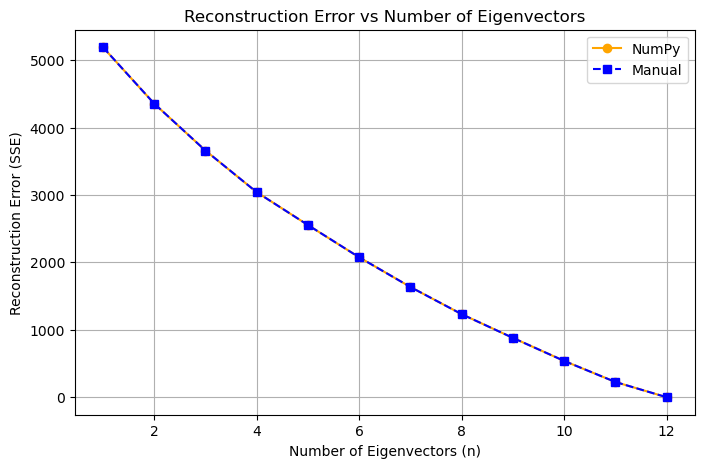

In [259]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(candidate_ns, errors_std, 'o-', color='orange', label='NumPy')
plt.plot(candidate_ns, errors, 's--', color='blue', label='Manual')  # Add manual implementation
plt.xlabel('Number of Eigenvectors (n)')
plt.ylabel('Reconstruction Error (SSE)')
plt.title('Reconstruction Error vs Number of Eigenvectors')
plt.legend()
plt.grid(True)
plt.show()
